In [4]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/",one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [8]:
def weight_variable(shape,name):
    return tf.Variable(tf.truncated_normal(shape=shape,stddev=0.1),name)
def bias_variable(shape,name):
    return tf.Variable(tf.constant(0.1,shape=shape),name)
def conv2d(x,W):
    return tf.nn.conv2d(x,W,strides=[1,2,2,1],padding="SAME")
def deconv2d(x,W,output_shape):
    return tf.nn.conv2d_transpose(x,W,output_shape,strides=[1,2,2,1],padding="SAME")

def build_graph():
    x_origin=tf.reshape(x,[-1,28,28,1])
    x_origin_noise=tf.reshape(x_noise,[-1,28,28,1])
    
    W_e_conv1=weight_variable([5,5,1,16],"w_e_conv1")
    b_e_conv1=bias_variable([16],"b_e_conv1")
    h_e_conv1=tf.nn.relu(tf.add(conv2d(x_origin_noise,W_e_conv1),b_e_conv1))
    
    W_e_conv2=weight_variable([5,5,16,32],"w_e_conv2")
    b_e_conv2=bias_variable([32],"b_e_conv2")
    h_e_conv2=tf.nn.relu(tf.add(conv2d(h_e_conv1,W_e_conv2),b_e_conv2))
    
    code_layer=h_e_conv2
    print("code layer shape : %s" % h_e_conv2.get_shape())
    
    W_d_conv1=weight_variable([5,5,16,32],"w_d_conv1")
    b_d_conv1=bias_variable([1],"b_d_conv1")
    output_shape_d_conv1=tf.stack([tf.shape(x)[0],14,14,16])
    h_d_conv1=tf.nn.relu(deconv2d(h_e_conv2,W_d_conv1,output_shape_d_conv1))
    
    W_d_conv2=weight_variable([5,5,1,16],"w_d_conv2")
    b_d_conv2=bias_variable([16],"b_d_conv2")
    output_shape_d_conv2=tf.stack([tf.shape(x)[0],28,28,1])
    h_d_conv2=tf.nn.relu(deconv2d(h_d_conv1,W_d_conv2,output_shape_d_conv2))
    
    x_reconstruct=h_d_conv2
    print("reconstruct layer shape : %s" % x_reconstruct.get_shape())
    
    return x_origin,code_layer,x_reconstruct

tf.reset_default_graph()
x=tf.placeholder(tf.float32,shape=[None,784])
x_noise=tf.placeholder(tf.float32,shape=[None,784])
x_origin,code_layer,x_reconstruct=build_graph()

code layer shape : (?, 7, 7, 32)
reconstruct layer shape : (?, ?, ?, ?)


In [9]:
cost=tf.reduce_mean(tf.pow(x_reconstruct-x_origin,2))
optimizer=tf.train.AdamOptimizer(0.01).minimize(cost)

sess=tf.InteractiveSession()
batch_size=50
init_op=tf.global_variables_initializer()
sess.run(init_op)

for epoch in range(10000):
    batch=mnist.train.next_batch(batch_size)
    batch_raw=batch[0]
    batch_noise=batch[0]+0.3*np.random.randn(batch_size,784)
    if epoch<1500:
        if epoch%100==0:
            print("step %d, loss %g" % (epoch, cost.eval(feed_dict={x:batch_raw,x_noise: batch_noise})))
    else:
        if epoch%1000==0:
            print("step %d, loss %g" % (epoch, cost.eval(feed_dict={x:batch_raw,x_noise: batch_noise})))
    optimizer.run(feed_dict={x:batch_raw,x_noise: batch_noise})
    
print("final loss %g" % cost.eval(feed_dict={x:mnist.test.images,x_noise:mnist.test.images}))



step 0, loss 0.110413
step 100, loss 0.00933632
step 200, loss 0.00783148
step 300, loss 0.00776095
step 400, loss 0.00680183
step 500, loss 0.00680812
step 600, loss 0.00683755
step 700, loss 0.00684202
step 800, loss 0.00633303
step 900, loss 0.00697558
step 1000, loss 0.00639042
step 1100, loss 0.00638796
step 1200, loss 0.00633161
step 1300, loss 0.00599551
step 1400, loss 0.00573107
step 2000, loss 0.00600646
step 3000, loss 0.00547753
step 4000, loss 0.00543926
step 5000, loss 0.00551826
step 6000, loss 0.00547817
step 7000, loss 0.00599547
step 8000, loss 0.00501975
step 9000, loss 0.00573388
final loss 0.00228592


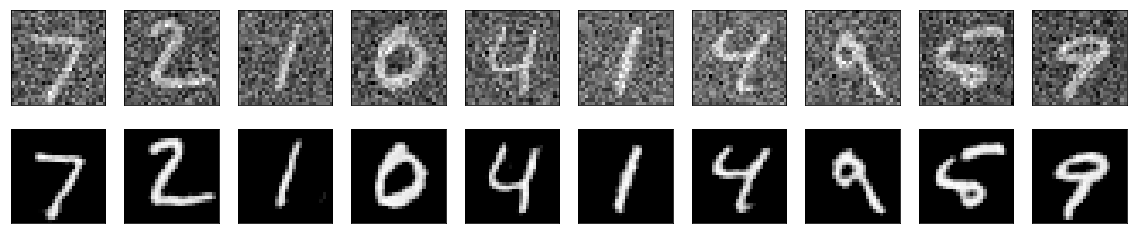

In [13]:
def plot_n_reconstruct(origin_img,reconstruct_img,n=10):
    plt.figure(figsize=(2*10,4))
    
    for i in range(n):
        ax=plt.subplot(2,n,i+1)
        plt.imshow(origin_img[i].reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax=plt.subplot(2,n,i+1+n)
        plt.imshow(reconstruct_img[i].reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

test_size=10
test_origin_img=mnist.test.images[0:test_size,:]
test_reconstruct_img=np.reshape(
    x_reconstruct.eval(feed_dict={x:test_origin_img,x_noise:test_origin_img+0.3*np.random.randn(10,784)}),[-1,28*28])
plot_n_reconstruct(test_origin_img+0.3*np.random.randn(10,784),test_reconstruct_img)

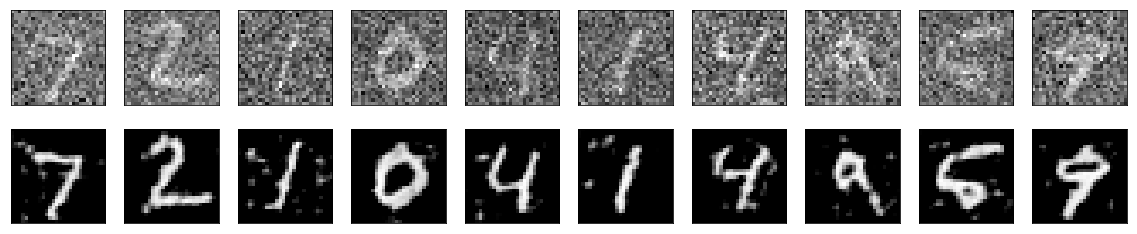

In [14]:
test_size = 10
test_origin_img = mnist.test.images[0:test_size, :]
test_reconstruct_img = np.reshape(x_reconstruct.eval(feed_dict = {x: test_origin_img, x_noise: test_origin_img + 0.5*np.random.randn(10, 784)}), [-1, 28 * 28])
plot_n_reconstruct(test_origin_img + 0.5*np.random.randn(10, 784), test_reconstruct_img)